# Initial Regressors and Predictors
Implements two models:
- A simple model in which we project forwards based on the difference with last month (surprisingly effective)
- A lagged OLS model with 6 lag periods, which was tested in two ways:
 - Raw data ($ZHVI), without any rescaling
 - Rescaled data (percent change between months), which rescales the data to be all relative to the current month.
 
Surprisingly, the OLS model with the rescaled model does worse than the diff model in Atlanta. This may be because we are overfitting our model, i.e. we should be using fewer/different lags.

In [59]:
import pandas as pd
import numpy  as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
% matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import sys, os, copy
print("Using environment in "+sys.prefix)
print("Python version "+sys.version)


Using environment in /Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env
Python version 3.5.2 (default, Oct 31 2016, 16:50:28) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]


In [60]:
fname = 'Metro_Zhvi_AllHomes.csv'

#  Map Zillow RegionID to metro area string
metroRegionID = {'Dallas-Fort Worth, TX':394514,
                     'Atlanta, GA':394347,
                     'Phoenix, AZ':394976,
                     'Las Vegas, NV':394775 }

metroString = {'Dallas':u'Dallas-Fort Worth, TX',
               'Atlanta':u'Atlanta, GA',
               'Phoenix':u'Phoenix, AZ',
               'Vegas':u'Las Vegas, NV'}

In [61]:
df = pd.read_csv('Data/ZHVI/'+fname,index_col=[1])
df = df.drop(['RegionID','SizeRank'],axis=1)
df.columns = pd.DatetimeIndex(df.columns)

In [62]:
def generateResults(myfunc,funcNameString, startDate=None, endDate=None):
    # Wrapper that will take a prediction function which is defined similar to the above.
    #  This function then generate plots of the results for each of the metro areas,
    #  Returns a Series with the RMSE (in percentage of housing price change)
    
    cityList = list(metroString.keys())
    cityList.sort()
    cityResults = pd.Series(name=funcNameString)
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,8))

    for i in range( len(metroString) ):
        # Prep index data for plotting
        twobits = '{0:02b}'.format(i)
        row = int(twobits[-1])
        col = int(twobits[-2])
        city = cityList[i]

        # Generate results
        ts = df.loc[metroString[city], startDate:endDate ]
        myResults = myfunc(ts)
        myResults = myResults # Scale to be percentages
        myResults['error'] = myResults['predicted'] - myResults['actual']
        rmse = np.sqrt(myResults['error'].pow(2).sum()/float(myResults.shape[0]))
        cityResults[city] = rmse

        # Plot results
        myResults.plot(style=[None,None,'r:'],ax=axes[row,col], title='%s RMSE= %.3f '%(city,rmse))
        axes[row,col].set_ylabel('6-month percent change in ZHVI(%)')

    # Clean up plot
    plt.suptitle("Prediction using "+funcNameString,fontsize=16)
    
    return cityResults

# Actual Models

In [5]:
# Simplest possible model: Just look at the current slope with respect to last month's measurement, and assume that this will continue till

def lastMeasure(ts):
    ts = ts['2006-01':]
    results = pd.DataFrame(columns = ['predicted','actual'])
    results['actual'] = ts.shift(-6)/ts - 1
    results['predicted']= (ts/ts.shift(1) - 1) * 6
    results = results.dropna()
    
    return results * 100

,Atlanta,Dallas,Phoenix,Vegas
Diff with Last Month,2.077602,2.3345,3.257202,3.474052


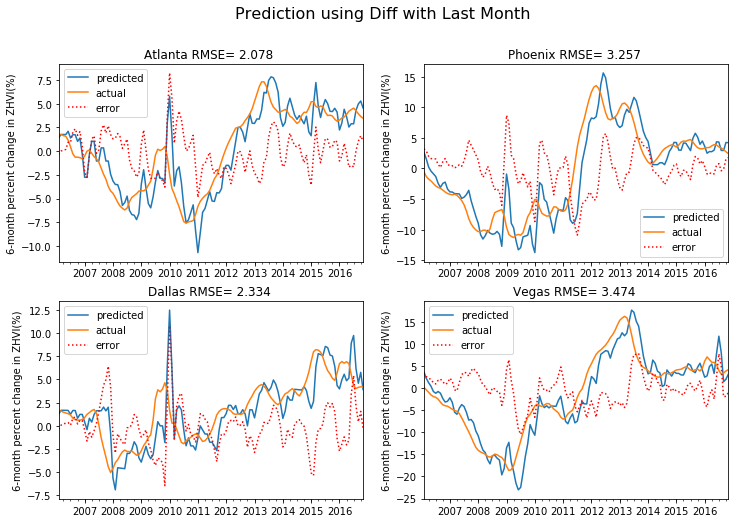

In [6]:
cityResults = generateResults(lastMeasure,'Diff with Last Month')
pd.DataFrame(cityResults).T

In [76]:
from sklearn.linear_model import LinearRegression

In [84]:
def laggedRegressor(ts):  
    # Takes in a time series of raw housing price data
    # Creates the target and all variables needed for the regressor.
    # Returns a dataframe with DateTimeIndex and columns ['predicted','actual'] where these are relative housing values
    
#     nlags = 3
    trainBefore = '2006-01'  # Use all dates before this as training data. Start rolling predictions after this.
    results = pd.DataFrame(columns = ['predicted','actual'])

    ## Toggle between these two lines to switch from original and rescaled OLS
    X = pd.concat([ts.shift(i) for i in range(nlags)], axis=1,keys = ['L%s'%i for i in range(nlags)])  # Original data (dollars)
#     X = pd.concat([ ((ts/ts.shift(i)-1)*(6. /i)) for i in range(1,nlags+1)], axis=1,keys = ['L%s'%i for i in range(nlags)]) # Scaled data (% change)

    X['y'] = ts.shift(-6) / ts - 1  # De-mean (i.e. want everything to be +/- percentages, with 0 being neutral)
    X['y'] = X['y'] * 100  # Convert to percentage
    X = X.dropna()
    X = X.assign(trend=np.arange(len(X)))
    X.head()
    
    # Convert that training date into a start and top time for our training set. Klugey, but it works (sort of)
    trainEndIndex = X.index.get_loc(trainBefore).stop
    trainingEnds  = X.index[trainEndIndex-1]
    testDate = X.index[trainEndIndex]
    testDateList = X.loc[trainingEnds:,:].index

    regr = LinearRegression()
    
    for testDate in testDateList:

        trainSet = X.loc[:trainingEnds,:]
        testSet = X.loc[testDate:testDate,:]

        results.loc[testDate,'actual']  = X.loc[testDate,'y']

        regr.fit(trainSet.drop('y',axis=1).values, trainSet['y'])
        results.loc[testDate,'predicted'] = regr.predict(testSet.drop('y',axis=1))[0]
        
        trainingEnds = testDate
    
    return results

Atlanta    1.970278
Dallas     2.371707
Phoenix    3.860039
Vegas      4.199966
Name: Lagged OLS, nlags=6, dtype: float64

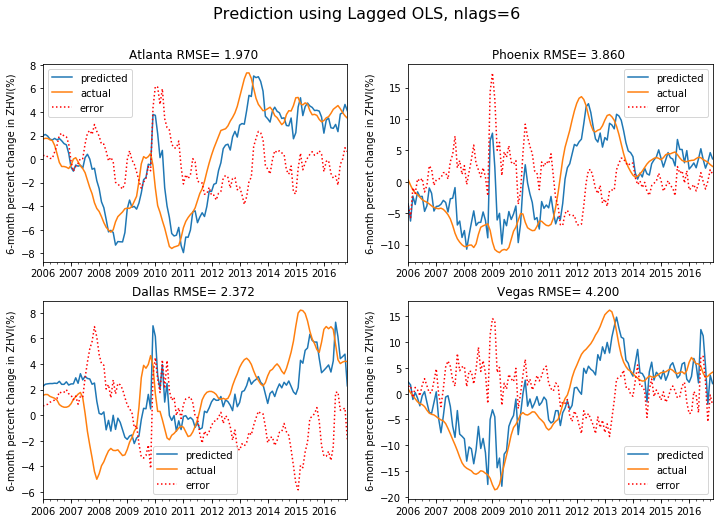

In [85]:
nlags = 6
modelString = 'Lagged OLS, nlags=%s'%nlags
generateResults(laggedRegressor,modelString)

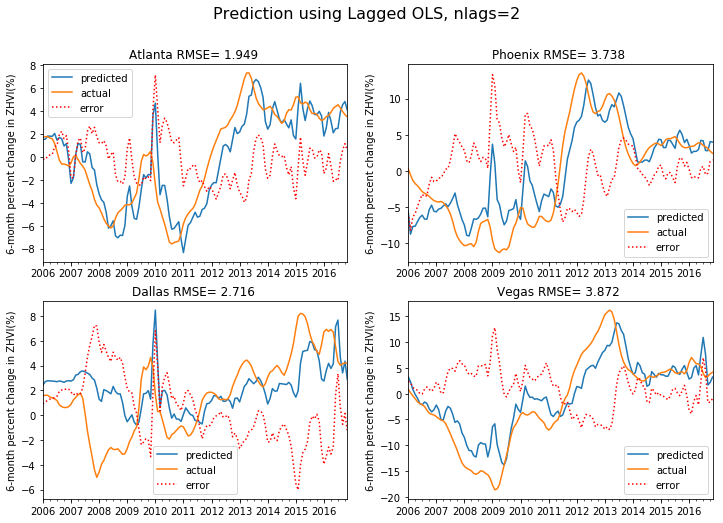

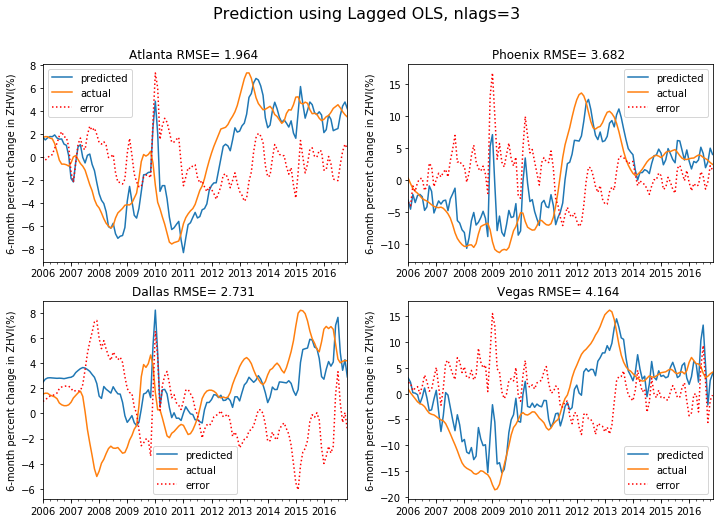

In [86]:
# Loop through a potential set of lags to see what the results are like: 
#  The model seems very prone to overfitting, so having a good set of results is helpful

cityResults = pd.DataFrame()

for nlags in range(2,4):
    modelString = 'Lagged OLS, nlags=%s'%nlags
    cityResults[modelString] = generateResults(laggedRegressor,modelString)
    fname = 'Data/Plots/Eric/LaggedOLS/LaggedOLS'+str(nlags)+'.pdf'
    plt.savefig(fname)
    

In [9]:
cityResults.T

,Atlanta,Dallas,Phoenix,Vegas
"Lagged OLS, nlags=2",1.949307,2.716096,3.738499,3.872352
"Lagged OLS, nlags=3",1.964010,2.730967,3.682500,4.163534


# Random Forest Regressor with lagged endogenous variables

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pickle

metroMonthly = pickle.load(open('Data/Summary/metroMonthly.pkl','rb'))
nationalMonthly = pickle.load(open('Data/Summary/nationalMonthly.pkl','rb'))

In [58]:
inputDf.columns.values

array(['L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'y', 'metroUnemployment',
       'metroLaborForce', 'stateInitialUnemplClaims',
       'stateContinuedUnemplClaims', 'stateLaborForce', 'metroIncome',
       'csi', 'cpi', 'natLaborForce'], dtype=object)

# To-do: 
- Replace patsy OLS with sklearn OLS and make sure it still works
- add standardscaler to sklearn OLS and make sure we understand the output
- Add additional data to sklearn OLS
- Run as lasso or ridge regression
- Run as random forest regression

In [ ]:
# def generateResults(myfunc,funcNameString, startDate=None, endDate=None):
#   myResults = myfunc(ts)

# def lastMeasure(ts):
#     ts = ts['2006-01':]
#     results = pd.DataFrame(columns = ['predicted','actual'])
#     results['actual'] = ts.shift(-6)/ts - 1
#     results['predicted']= (ts/ts.shift(1) - 1) * 6
#     results = results.dropna()
    
#     return results * 100

def randForest(ts):

    nlags = 3
    trainBefore = '2006-01'  # Use all dates before this as training data. Start rolling predictions after this.
    results = pd.DataFrame(columns = ['predicted','actual'])

    ## Toggle between these two lines to switch from original and rescaled OLS
    inputData = pd.concat([ts.shift(i) for i in range(nlags)], axis=1,keys = ['L%s'%i for i in range(nlags)])  # Original data (dollars)
#     inputData = pd.concat([ ((ts/ts.shift(i)-1)*(6. /i)) for i in range(1,nlags+1)], axis=1,keys = ['L%s'%i for i in range(nlags)]) # Scaled data (% change)

    metroData = metroMonthly[city].loc[inputDf.index,:]
    metroData = metroData.dropna(axis=1, how='any')
    natlData  = nationalMonthly.loc[ts.index[0]:ts.index[-1],:]
    natlData  = natlData.dropna(axis=1, how='any')
    exogVars  = metroData.join(natlData)

    inputDf = inputDf.join(exogVars)
    
    inputData['y'] = ts.shift(-6) / ts - 1  # De-mean (i.e. want everything to be +/- percentages, with 0 being neutral)
    inputData['y'] = inputData['y'] * 100  # Convert to percentage
    
    inputData = inputData.dropna()
    
    # Convert that training date into a start and top time for our training set. Klugey, but it works (sort of)
    trainEndIndex = inputData.index.get_loc(trainBefore).stop
    trainingEnds  = inputData.index[trainEndIndex-1]
    testDate = inputData.index[trainEndIndex]
    testDateList = inputData.loc[trainingEnds:,:].index
    
    myForest = RandomForestRegressor()

    for testDate in testDateList:

        trainSet = X.loc[:trainingEnds,:]
        testSet = X.loc[testDate:testDate,:]

        results.loc[testDate,'actual']  = X.loc[testDate,'y']
        
        eqn = 'y ~ trend + ' + ' + '.join(['L%s'%i for i in range(nlags)])
        mod_lagged = smf.ols(eqn, data=trainSet)
        res_lagged = mod_lagged.fit()
        results.loc[testDate,'predicted'] = res_lagged.predict(testSet.drop('y',axis=1)).values[0]

        trainingEnds = testDate
    
    return results


In [ ]:
Y = inputDf['y']
X = inputDf.drop(['y'], axis=1)

In [44]:
i = 0
startDate = None
endDate = None
nlags = 6

cityList = list(metroString.keys())
cityList.sort()
city = cityList[i]
ts = df.loc[metroString[city], startDate:endDate ]

# X = pd.concat([ts.shift(i) for i in range(nlags)], axis=1,keys = ['L%s'%i for i in range(nlags)])  # Original data (dollars)
inputDf = pd.concat([ ((ts/ts.shift(i)-1)*(6. /i)) for i in range(1,nlags+1)], axis=1,keys = ['L%s'%i for i in range(nlags)]) # Scaled data (% change)
inputDf.head()
inputDf['y'] = (ts.shift(-6) / ts - 1)*100.  # De-mean (i.e. want everything to be +/- percentages, with 0 being neutral)
inputDf = inputDf.dropna(axis=0,how='any')

## Exogenous Variables
# Compile exogenous variables for that city
metroData = metroMonthly[city].loc[inputDf.index,:]
metroData = metroData.dropna(axis=1, how='any')
natlData  = nationalMonthly.loc[ts.index[0]:ts.index[-1],:]
natlData  = natlData.dropna(axis=1, how='any')
exogVars  = metroData.join(natlData)

inputDf = inputDf.join(exogVars)


In [55]:
Y = inputDf['y']
X = inputDf.drop(['y'], axis=1)

xScaler = StandardScaler()
x = xScaler.fit_transform(X)

yScaler = StandardScaler()
y = yScaler.fit_transform(Y.reshape(-1,1))

In [56]:
x.shape

(242, 15)

In [57]:
y.shape

(242, 1)

In [42]:
inputDf.dropna(axis=0,how='any').head()

,L0,L1,L2,L3,L4,L5,y,metroUnemployment,metroLaborForce,stateInitialUnemplClaims,stateContinuedUnemplClaims,stateLaborForce,csi,cpi,natLaborForce
1996-10-01,0.011225,0.005613,0.001869,0.001402,0.001121,0.003749,0.021475,4.060429,2096330.0,23125.0,147322.0,3288279.0,106.6,158.3,1.140568e+08
1996-11-01,0.022409,0.016838,0.011225,0.007009,0.005607,0.004673,0.022326,4.173666,2106206.0,33350.0,192139.0,3299516.0,107.5,158.6,1.142689e+08
1996-12-01,0.022326,0.022409,0.018709,0.014032,0.010093,0.008411,0.025023,4.200807,2113832.0,28948.0,161012.0,3310754.0,104.9,158.6,1.144809e+08
1997-01-01,0.022243,0.022326,0.022409,0.019645,0.015716,0.012150,0.027701,4.138626,2119689.0,55169.0,239101.0,3321991.0,106.8,159.1,1.146930e+08
1997-02-01,0.022161,0.022243,0.022326,0.022409,0.020206,0.016838,0.030359,4.045382,2125856.0,25149.0,170473.0,3336950.0,107.2,159.6,1.149159e+08


In [37]:
inputDf.dropna(axis=0,how='any').head()

,L0,L1,L2,L3,L4,L5,y,metroUnemployment,metroLaborForce,stateInitialUnemplClaims,stateContinuedUnemplClaims,stateLaborForce,csi,cpi,natLaborForce
1996-04-01,NaN,NaN,NaN,NaN,NaN,NaN,0.003749,3.840214,2037621.0,22840.0,146456.0,3227691.0,107.8,156.3,1.128525e+08
1996-05-01,0.016870,NaN,NaN,NaN,NaN,NaN,0.004673,3.851044,2047938.0,21319.0,135405.0,3238055.0,105.1,156.6,1.130659e+08
1996-06-01,0.000000,0.008435,NaN,NaN,NaN,NaN,0.008411,3.825596,2057457.0,32620.0,172358.0,3248419.0,105.4,156.7,1.132793e+08
1996-07-01,0.000000,0.000000,0.005623,NaN,NaN,NaN,0.012150,3.810934,2066370.0,32192.0,160918.0,3258783.0,107.5,157.0,1.134927e+08
1996-08-01,-0.005607,-0.002804,-0.001869,0.002812,NaN,NaN,0.016838,3.834427,2075408.0,29021.0,191326.0,3268615.0,107.8,157.3,1.136807e+08


In [32]:
xScaler = StandardScaler()
x = xScaler.fit_transform(X)

yScaler = StandardScaler()
y = yScaler.fit_transform(X)

In [33]:
X.head()

,metroUnemployment,metroLaborForce,stateInitialUnemplClaims,stateContinuedUnemplClaims,stateLaborForce,csi,cpi,natLaborForce
1996-04-01,3.840214,2037621.0,22840.0,146456.0,3227691.0,107.8,156.3,1.128525e+08
1996-05-01,3.851044,2047938.0,21319.0,135405.0,3238055.0,105.1,156.6,1.130659e+08
1996-06-01,3.825596,2057457.0,32620.0,172358.0,3248419.0,105.4,156.7,1.132793e+08
1996-07-01,3.810934,2066370.0,32192.0,160918.0,3258783.0,107.5,157.0,1.134927e+08
1996-08-01,3.834427,2075408.0,29021.0,191326.0,3268615.0,107.8,157.3,1.136807e+08
